In [1]:
import pandas as pd
import numpy as np
import os
import operator
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import _name_estimators
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import log_loss
from sklearn.cross_validation import cross_val_score

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
import xgboost

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Data and Pre-processing

In [3]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

train = train[train.payprice >= train.slotprice]
validation = validation[validation.payprice >= validation.slotprice]

train['size'] = train['slotwidth'] * train['slotheight']
validation['size'] = validation['slotwidth'] * validation['slotheight']
test['size'] = test['slotwidth'] * test['slotheight']

train['OS'], train['browser'] = zip(*train['useragent'].map(lambda x: x.split('_')))
validation['OS'], validation['browser'] = zip(*validation['useragent'].map(lambda x: x.split('_')))
test['OS'], test['browser'] = zip(*test['useragent'].map(lambda x: x.split('_')))

In [4]:
def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['click','bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'bidprice','payprice','domain','slotwidth', 'slotheight'],axis=1)
    
    # create dummy variables for categoricals
    pred=pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour', 
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred=pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred


def pre_process_data_test(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'domain','slotwidth', 'slotheight'],axis=1)
    
       # create dummy variables for categoricals
    pred = pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour',  # ])
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred = pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred

In [5]:
train_dum = pre_process_data(train)
valid_dum = pre_process_data(validation,enforce_cols=train_dum.columns)
test_dum = pre_process_data_test(test,enforce_cols=train_dum.columns)

Input shape:	(2418578, 28)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


After converting categoricals:	(2418578, 743)
Input shape:	(302408, 28)
After converting categoricals:	(302408, 741)
['creative_7324' 'creative_7332']
[]
Input shape:	(303375, 25)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


After converting categoricals:	(303375, 741)
['creative_7324' 'creative_7327']
[]


In [6]:
def order(df_test, df_train):
    new_df = pd.DataFrame()
    
    for key in df_train:
        new_df[key] = df_test[key]
    return new_df

In [7]:
y = train.click
y_validation = validation.click

X_validation = order(valid_dum,train_dum)
X_test = order(test_dum,train_dum)

rus = RandomUnderSampler(random_state=3,ratio={1:1786,0:10716})
X_train,y_train = rus.fit_sample(train_dum,y)

# CRT Prediction

## 1.Train XGBoost

In [8]:
#train XGBoost

xgb_model = xgboost.XGBClassifier()
parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate':[0.05],
              'max_depth':[5,6,9], 
              'min_child_weight':[1,3],
              'silent':[0],
              'subsample':[0.8],
              'colsample_bytree':[0.8],
              'n_estimators':[50,100,200],
              'missing':[-999],
              'seed':[1337]
             }
model_xgb = GridSearchCV(xgb_model, param_grid=parameters, n_jobs=5,
                       cv=StratifiedKFold(y_train, n_folds=10,shuffle=True),
                       scoring='roc_auc',
                       verbose=2,
                       refit=True)
model_xgb.fit(X_train, y_train)

best_parameters, score, _ = max(model_xgb.grid_scores_, key=lambda x:x[1])
print('Raw ACU score', score)

for param_name in sorted(best_parameters.keys()):
    print("%s: %r"%(param_name, best_parameters[param_name]))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsam

[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.4min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.4min
[CV]  colsample_bytree=0.8, learning_rat

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  5.5min


[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  22.4s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  22.4s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  23.3s
[CV] colsample_bytree=0.8, lea

[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.3min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.3min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rat

[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  53.5s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  49.4s
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  49.2s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV] colsample_bytree=0.8

[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  28.9s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  29.0s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=

[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.7min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.7min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=6, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.7min
[CV] colsample_bytree=0.8, 

[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=100, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 1.4min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 2.7min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=1, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rat

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 32.7min


[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  40.9s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  40.0s
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=50, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total=  39.3s
[CV] colsample_bytree=0.8, lea

[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 2.5min
[CV] colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 2.4min
[CV]  colsample_bytree=0.8, learning_rate=0.05, max_depth=9, min_child_weight=3, missing=-999, n_estimators=200, nthread=4, objective=binary:logistic, seed=1337, silent=0, subsample=0.8, total= 2.4min
[CV]  colsample_bytree=0.

[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed: 40.8min finished


Raw ACU score 0.8731063065032875
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 5
min_child_weight: 3
missing: -999
n_estimators: 200
nthread: 4
objective: 'binary:logistic'
seed: 1337
silent: 0
subsample: 0.8


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## 2.Train Logistic Regression

In [9]:
#train Logistic Regression
#parameters={'C':[0.01,0.05,0.1,0.2,0.5],
#     'solver':['liblinear','saga'],
#     'penalty':['l1','l2'],
#     'max_iter':[100,300,500]}
#
#lr = LogisticRegression(class_weight='balanced')
#strk = StratifiedKFold(10,random_state=666,shuffle=True)
#
#model_lr = GridSearchCV(lr,parameters,scoring='roc_auc',cv=strk,verbose=3)
#model_lr.fit(X_train, y_train)
#model_lr.best_params_,model_lr.best_score_

## 3.Compare Different models
### 1.Logidtic Regression  2.Decision Tree   3.Random Forest   4.XGBoost   5.Ensemble Method

In [9]:
class MajorityVoteClassifier(BaseEstimator,
                            ClassifierMixin):
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
        
    def fit(self, X, y):     
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                              self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else: # 'classlabel' vote
             # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                           lambda x:
                           np.argmax(np.bincount(x,
                                        weights=self.weights)),
                           axis=1,
                           arr=predictions)

        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
                                     
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas,
                               axis=0, weights=self.weights)
        return avg_proba
            
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in\
                    six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


In [10]:
clf1 = LogisticRegression(penalty = 'l1', max_iter = 100, C = 0.1,
                          solver = 'saga',class_weight = 'unbalanced')
clf2 = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)
clf3 = RandomForestClassifier(n_estimators = 50, random_state = 0)
clf4 = xgboost.XGBClassifier(max_depth = 6, n_estimators = 100, learning_rate = 0.05, 
                             silent = 0,subsample = 0.8, min_child_weight = 3, 
                             objective = 'binary:logistic',colsample_bytree = 0.8)

In [11]:
clf_labels = ['Logistic Regression','Decision Tree','Random Forest','XGBoost']

In [12]:
X_validation = X_validation.as_matrix()

In [13]:
mv_clf = MajorityVoteClassifier(classifiers = [clf1,clf3,clf4])
clf_labels += ['Majority Voting']
all_clf = [clf1,clf2,clf3,clf4,mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("ROC AUC: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.8228 (+/- 0.01) [Logistic Regression]
ROC AUC: 0.7217 (+/- 0.01) [Decision Tree]
ROC AUC: 0.8261 (+/- 0.01) [Random Forest]
ROC AUC: 0.8726 (+/- 0.01) [XGBoost]
ROC AUC: 0.8565 (+/- 0.01) [Majority Voting]


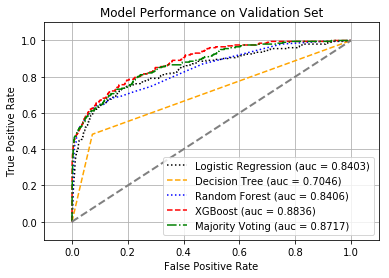

In [14]:
#Evaluating and tuning the ensemble classifier
colors = ['black','orange','blue','red','green']
linestyles = [':','--',':','--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):
     # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_validation)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_validation,
                                     y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color = clr,linestyle = ls,
             label = '%s (auc = %0.4f)' % (label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = 'gray',
         linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Performance on Validation Set')
plt.show()

In [15]:
mv_clf1 = MajorityVoteClassifier(classifiers = [clf1,clf3,clf4])
mv_clf2 = MajorityVoteClassifier(classifiers = [clf1,clf2,clf3])
mv_clf3 = MajorityVoteClassifier(classifiers = [clf3,clf4])
mv_clf4 = MajorityVoteClassifier(classifiers = [clf4])
clf_labels = ['Ensemble1','Ensemble2','Ensemble3','XGBoost']

all_clf = [mv_clf1,mv_clf2,mv_clf3,mv_clf4]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("ROC AUC: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.8565 (+/- 0.01) [Ensemble1]
ROC AUC: 0.8388 (+/- 0.01) [Ensemble2]
ROC AUC: 0.8583 (+/- 0.01) [Ensemble3]
ROC AUC: 0.8726 (+/- 0.01) [XGBoost]


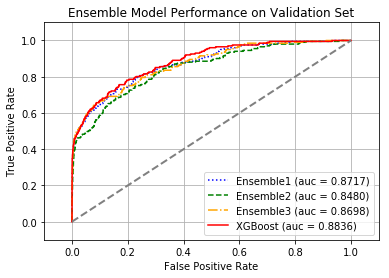

In [16]:
#Evaluating and tuning the ensemble classifier
colors = ['blue','green','orange','red']
linestyles = [':','--', '-.','-']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):
     # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_validation)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_validation,
                                     y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color = clr,linestyle = ls,
             label = '%s (auc = %0.4f)' % (label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = 'gray',
         linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model Performance on Validation Set')
plt.show()

# XGBoost: Best CTR Prediction Model

In [17]:
model_CTR = xgboost.XGBClassifier(max_depth = 6, n_estimators=100, learning_rate=0.05, 
                                  silent = 0, subsample = 0.8, min_child_weight=3, 
                                  objective='binary:logistic',colsample_bytree=0.8)
model_CTR.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
       subsample=0.8)

In [19]:
y_valid_pre = model_CTR.predict_proba(X_validation)

X_test = X_test.as_matrix()
y_test_pre = model_CTR.predict_proba(X_test)

w = 10716/train.shape[0]
avgCTR = sum(train.click)/train.shape[0]

test_score = y_test_pre[:,1]/(y_test_pre[:,1]+(1-y_test_pre[:,1])/w)
valid_score = y_valid_pre[:,1]/(y_valid_pre[:,1]+(1-y_valid_pre[:,1])/w)

validation = validation.reset_index()

# Bidding Estimation

## 1.Linear Bidding

In [20]:
eval_linear = pd.DataFrame(columns=['bid_base','Imps','spend','clicks'])

max_num = 0
max_bid = 0
spend = 0
iteration = 0

for bid_base in np.arange(3,300, 3):
    num_click = 0
    flag = True
    Imps = 0
    spend = 0
    iteration += 1
    for i in range(validation.shape[0]):
        bid = bid_base*(valid_score[i]/avgCTR)
        if bid >= validation.payprice[i] and flag:
            spend = spend + validation.payprice[i]
            if spend > 6250000:
                spend = spend - validation.payprice[i]
                flag = False
                break
            num_click = num_click + validation.click[i]
            Imps = Imps + 1
    eval_linear.loc[iteration,'bid_base'] = bid_base
    eval_linear.loc[iteration,'clicks'] = num_click
    eval_linear.loc[iteration,'spend'] = spend/1000
    eval_linear.loc[iteration,'Imps'] = Imps

    if num_click > max_num:
        max_num = num_click
        max_bid = bid_base
        
eval_linear['CTR'] = eval_linear['clicks']/eval_linear['Imps']
eval_linear['eCPC'] = eval_linear['spend']/eval_linear['clicks']
eval_linear['CPM'] = eval_linear['spend']*1000/eval_linear['Imps']

In [21]:
eval_linear.iloc[np.where(eval_linear.clicks == eval_linear.clicks.max())[0]]

,bid_base,Imps,spend,clicks,CTR,eCPC,CPM
42,126,140499,6209.82,160,0.0011388,38.8114,44.1983


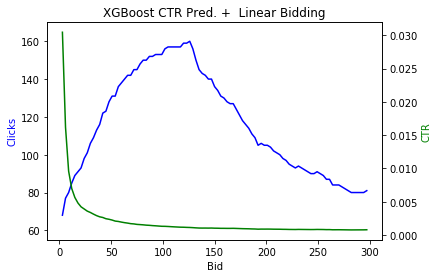

In [22]:
first_line = eval_linear[['bid_base','clicks']].astype(float)
second_line = eval_linear[['bid_base','CTR']].astype(float)

fig, ax1 = plt.subplots()
ax1.plot(first_line.bid_base,first_line.clicks, color='b')
ax1.set_xlabel('Bid')
ax1.set_ylabel('Clicks', color='b')
ax1.set_ylim([55,170])

ax2 = ax1.twinx()
ax2.plot(second_line.bid_base, second_line.CTR, color='g')
ax2.set_ylabel('CTR', color='g')
plt.title("XGBoost CTR Pred. +  Linear Bidding")
plt.show()

## 2.Quadratic Bidding

In [22]:
# function
#bid = base_bid * (pCTR / avgCTR)^2
eval_nonlinear = pd.DataFrame(columns=['bid_base','Imps','spend','clicks'])

max_num = 0
max_bid = 0
spend = 0
iteration = 0

for bid_base in np.arange(3,300, 3):
    num_click = 0
    flag = True
    Imps = 0
    spend = 0
    iteration += 1
    for i in range(validation.shape[0]):
        bid = bid_base*(valid_score[i]/avgCTR)**2
        if bid >= validation.payprice[i] and flag:
            spend = spend + validation.payprice[i]
            if spend > 6250000:
                spend = spend - validation.payprice[i]
                flag = False
                break
            num_click = num_click + validation.click[i]
            Imps = Imps + 1
    eval_nonlinear.loc[iteration,'bid_base'] = bid_base
    eval_nonlinear.loc[iteration,'clicks'] = num_click
    eval_nonlinear.loc[iteration,'spend'] = spend/1000
    eval_nonlinear.loc[iteration,'Imps'] = Imps
    #print(num_click)
    if num_click > max_num:
        #print('increase')
        max_num = num_click
        max_bid = bid_base
        
eval_nonlinear['CTR'] = eval_nonlinear['clicks']/eval_nonlinear['Imps']
eval_nonlinear['eCPC'] = eval_nonlinear['spend']/eval_nonlinear['clicks']
eval_nonlinear['CPM'] = eval_nonlinear['spend']*1000/eval_nonlinear['Imps']

In [25]:
eval_nonlinear.iloc[np.where(eval_nonlinear.clicks == eval_nonlinear.clicks.max())[0]]

,bid_base,Imps,spend,clicks,CTR,eCPC,CPM
65,195,116315,6225.32,165,0.00141856,37.7292,53.5212


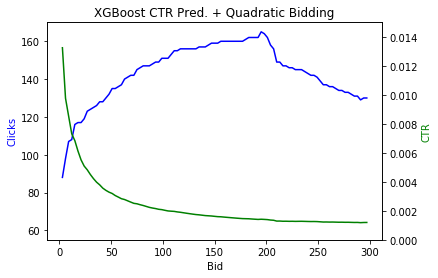

In [26]:
first_line = eval_nonlinear[['bid_base','clicks']].astype(float)
second_line = eval_nonlinear[['bid_base','CTR']].astype(float)

fig, ax1 = plt.subplots()
ax1.plot(first_line.bid_base,first_line.clicks, color='b')
ax1.set_xlabel('Bid')
ax1.set_ylabel('Clicks', color='b')
ax1.set_ylim([55,170])

ax2 = ax1.twinx()
ax2.plot(second_line.bid_base, second_line.CTR, color='g')
ax2.set_ylabel('CTR', color='g')
ax2.set_ylim([0,0.015])
plt.title("XGBoost CTR Pred. + Quadratic Bidding")
plt.show()

## 3.ORTB Bidding

In [32]:
# funtion
# bid = sqrt(c/lambda pctr + c^2) - c
eval_ORTB = pd.DataFrame(columns=['best_c','best_lambda','Imps','spend','clicks'])

iteration = 0
max_num = 0
max_bid = 0
spend = 0
best_lambda = 0
best_c = 0
#lambda_range = [1e-8,5e-8,1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4,5e-4]
lambda_range = [5e-7,1e-6,5e-6]
for c in np.arange(4,25,2):
    for m in lambda_range:
        num_click = 0
        flag = True
        Imps = 0
        spend = 0
        iteration += 1
        size = validation.shape[0]

        for i in range(validation.shape[0]):
            bid = np.sqrt(c / m * valid_score[i] + c ** 2) - c

            if bid >= validation.payprice[i] and flag:
                spend = spend + validation.payprice[i]
                if spend > 6250000:
                    spend = spend - validation.payprice[i]
                    flag = False
                    break
                num_click = num_click + validation.click[i]
                Imps = Imps + 1
            
        eval_ORTB.loc[iteration,'clicks'] = num_click
        eval_ORTB.loc[iteration,'spend'] = spend/1000
        eval_ORTB.loc[iteration,'Imps'] = Imps


        if num_click > max_num:
            max_num = num_click
            best_lambda = m
            best_c = c
            
        eval_ORTB.loc[iteration,'best_c'] = best_c
        eval_ORTB.loc[iteration,'best_lambda'] = best_lambda

            
eval_ORTB['CTR'] = eval_ORTB['clicks']/eval_ORTB['Imps']
eval_ORTB['eCPC'] = eval_ORTB['spend']/eval_ORTB['clicks']
eval_ORTB['CPM'] = eval_ORTB['spend']*1000/eval_ORTB['Imps']
            

In [34]:
eval_ORTB.iloc[np.where(eval_ORTB.clicks == eval_ORTB.clicks.max())[0]]

,best_c,best_lambda,Imps,spend,clicks,CTR,eCPC,CPM
17,20,1e-06,151036,6194.8,159,0.00105273,38.961,41.0154


## 4.Exponential Bidding

In [29]:
# function
#bid = base_bid * exp(pCTR / avgCTR)
eval_exp = pd.DataFrame(columns=['bid_base','Imps','spend','clicks'])

max_num = 0
max_bid = 0
spend = 0
iteration = 0

#for bid_base in np.arange(3,303, 3):
for bid_base in np.arange(3,150,3):
    num_click = 0
    flag = True
    Imps = 0
    spend = 0
    iteration += 1
    for i in range(validation.shape[0]):
        bid = bid_base * np.exp(valid_score[i]/avgCTR)
        if bid >= validation.payprice[i] and flag:
            spend = spend + validation.payprice[i]
            if spend > 6250000:
                spend = spend - validation.payprice[i]
                flag = False
                break
            num_click = num_click + validation.click[i]
            Imps = Imps + 1
    eval_exp.loc[iteration,'bid_base'] = bid_base
    eval_exp.loc[iteration,'clicks'] = num_click
    eval_exp.loc[iteration,'spend'] = spend/1000
    eval_exp.loc[iteration,'Imps'] = Imps

    if num_click > max_num:
        max_num = num_click
        max_bid = bid_base
        
eval_exp['CTR'] = eval_exp['clicks']/eval_exp['Imps']
eval_exp['eCPC'] = eval_exp['spend']/eval_exp['clicks']
eval_exp['CPM'] = eval_exp['spend']*1000/eval_exp['Imps']

In [30]:
eval_exp.iloc[np.where(eval_exp.clicks == eval_exp.clicks.max())[0]]

,bid_base,Imps,spend,clicks,CTR,eCPC,CPM
12,36,145734,5964.13,157,0.00107731,37.9881,40.9248
